In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pprint import pprint
import gc
from collections import deque
from tqdm.notebook import tqdm
from time import sleep
import pickle
from datetime import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Activation, Reshape, Concatenate
from tensorflow.keras.models import Model as KerasModel
from sklearn.model_selection import train_test_split
from collections import deque

In [2]:
train = pd.read_csv('sales_train_cleaned.csv')
item_df = pd.read_csv('items.csv')
shops_df = pd.read_csv('shops.csv')

# Merging Mislabelled Shops

upon manually going through the data of the shops, discoveredthe following possible cases where the same shop have been given different shop_id, hence merging them together. The shops of interest are:
1. 0 => 57 (This is contentious)
2. 1 => 58 (This is contentious)
3. 10 => 11

In [3]:
train.loc[(train.shop_id == 0), 'shop_id'] = 57
train.loc[(train.shop_id == 1), 'shop_id'] = 58
train.loc[(train.shop_id == 10),'shop_id'] = 11

In [4]:
train['date'] = train['date'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))

train['day'] = train.date.apply(lambda x: int(x.strftime('%d')))
train['month'] = train.date.apply(lambda x: int(x.strftime('%m')))
train['year'] = train.date.apply(lambda x: int(x.strftime('%Y')))

In [5]:
train = pd.merge(train,item_df,on=['item_id'])

In [6]:
# Determine the monthly item count
monthly_sales = train.groupby(['shop_id','item_id','date_block_num'])['item_cnt_day'].sum().to_frame().reset_index()
monthly_sales.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=True)

In [7]:
gc.collect()

0

# Embedding

The variabls we want to apply entity embeddings to are the following variables:
1. **shop_id**
2. **item_category_id**
3. **years**
4. **months**

In [8]:
# General rule of thumb for the embedding of categorical data
num_shop_id = len(shops_df)
num_category_id = len(item_df['item_category_id'].unique())
num_years = 3
num_months = 12

# embedding_size = min(50, m+1/ 2) 
num_shop_id_embeddings = 3
num_cat_id_embeddings = 3
num_years_embeddings = 2
num_months_embeddings = 4

In [469]:
# Create a function that takes in a feature set and created the one hot enconding data frame
def generate_one_hot_encoding(data, feature):
    # get the unique list of feature values
    unique_values = list(data[feature].unique())
    unique_values.sort()
    max_val = unique_values[-1]
    one_hot_encoded = np.zeros((max_val+1,max_val+2)) # Extra column for indexing
    one_hot_encoded = one_hot_encoded.astype(int)
    for idx in unique_values:
        one_hot_encoded[idx,idx+1] = 1
        one_hot_encoded[idx,0] = int(idx)
    columns = [feature]
    for i in range(max_val+1):
        columns.append(feature+"_"+str(i))
    df = pd.DataFrame(data=one_hot_encoded,columns=columns)
    return df

In [474]:
shop_id_hot_encode = generate_one_hot_encoding(monthly_sales,"shop_id")
category_id_hot_encode = generate_one_hot_encoding(item_df,"item_category_id")
year_hot_encode = generate_one_hot_encoding(train,"year")

In [9]:
monthly_sales

,shop_id,item_id,date_block_num,item_cnt_month
0,2,27,0,1.0
1,2,27,17,1.0
2,2,30,2,1.0
3,2,30,5,1.0
4,2,30,15,1.0
...,...,...,...,...
1609117,59,22164,27,2.0
1609118,59,22164,30,1.0
1609119,59,22167,9,1.0
1609120,59,22167,11,2.0


In [10]:
# Adding item_category_id
train_embedding_data = pd.merge(monthly_sales, item_df, on=["item_id"])
train_embedding_data.drop(["item_name"],inplace=True,axis=1)

In [11]:
# Adding year
year_block_num = train[['date_block_num','year']].drop_duplicates()
train_embedding_data = pd.merge(train_embedding_data, year_block_num, on=['date_block_num'])

In [12]:
# Adding months
month_block_num = train[['date_block_num','month']].drop_duplicates()
train_embedding_data = pd.merge(train_embedding_data, month_block_num, on=['date_block_num'])

In [13]:
# Adding label encoded years
year_label_encoded = pd.DataFrame(data=np.array([[2013,0],[2014,1],[2015,2]]),columns=['year','year_label_encoded'])
year_label_encoded

,year,year_label_encoded
0,2013,0
1,2014,1
2,2015,2


In [14]:
train_embedding_data = pd.merge(train_embedding_data, year_label_encoded, on=['year'])

In [15]:
# Label encoding the shop_id due to merging
unique_shop_id = train_embedding_data.shop_id.unique()
unique_shop_id = list(unique_shop_id.astype(int))
unique_shop_id.sort()
le = LabelEncoder()
le.fit(unique_shop_id)
shop_id_encoded = le.transform(train_embedding_data['shop_id'].values)

In [16]:
train_embedding_data.insert(1,"shop_id_label_encoded",
                            list(shop_id_encoded), True)

In [17]:
le.classes_

array([ 2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59])

In [18]:
input_shop = Input(shape=(1,))
output_shop = Embedding(57, num_shop_id_embeddings, name='shop_embedding')(input_shop)
output_shop = Reshape(target_shape=(num_shop_id_embeddings,))(output_shop)

input_item_cat = Input(shape=(1,))
output_item_cat = Embedding(num_category_id, num_cat_id_embeddings, name='item_cat_embedding')(input_item_cat)
output_item_cat = Reshape(target_shape=(num_cat_id_embeddings,))(output_item_cat)

# In the future maybe one hot encode of which days of the week the store was open
# input_dow = Input(shape=(1,))
# output_dow = Embedding(7, 6, name='dow_embedding')(input_dow)
# output_dow = Reshape(target_shape=(6,))(output_dow)

# Days the item price was below the median?
# input_promo = Input(shape=(1,))
# output_promo = Dense(1)(input_promo)

input_year = Input(shape=(1,))
output_year = Embedding(3, num_years_embeddings, name='year_embedding')(input_year)
output_year = Reshape(target_shape=(num_years_embeddings,))(output_year)

input_month = Input(shape=(1,))
output_month = Embedding(12,num_months_embeddings, name='month_embedding')(input_month)
output_month = Reshape(target_shape=(num_months_embeddings,))(output_month)

# input_day = Input(shape=(1,))
# output_day = Embedding(31, 10, name='day_embedding')(input_day)
# output_day = Reshape(target_shape=(10,))(output_day)

# input_germanstate = Input(shape=(1,))
# output_germanstate = Embedding(12, 6, name='state_embedding')(input_germanstate)
# output_germanstate = Reshape(target_shape=(6,))(output_germanstate)

input_model = [input_shop, input_item_cat, input_year, input_month]

output_embeddings = [output_shop, output_item_cat, output_year, output_month]

output_model = Concatenate()(output_embeddings)
output_model = Dense(50, kernel_initializer="uniform")(output_model)
output_model = Activation('relu')(output_model)
output_model = Dense(15, kernel_initializer="uniform")(output_model)
output_model = Activation('relu')(output_model)
output_model = Dense(1)(output_model)
output_model = Activation('sigmoid')(output_model)

model_2 = KerasModel(inputs=input_model, outputs=output_model)

model_2.compile(loss='mean_absolute_error', optimizer='adam')

In [19]:
# Setting data up for training
train_embedding_data = train_embedding_data[['shop_id_label_encoded',
                                             'item_category_id',
                                             'year_label_encoded',
                                             'month',
                                             'item_id',
                                             'date_block_num',
                                             'year',
                                             'shop_id',
                                             'item_cnt_month']]

In [20]:
train_embedding_data.drop(['date_block_num'], inplace=True, axis=1)

In [21]:
train_embedding_data.drop(['item_id','year','shop_id'], inplace=True, axis=1)

In [22]:
train_embedding_data

,shop_id_label_encoded,item_category_id,year_label_encoded,month,item_cnt_month
0,0,19,0,1,1.0
1,8,19,0,1,1.0
2,16,19,0,1,1.0
3,23,19,0,1,1.0
4,28,19,0,1,1.0
...,...,...,...,...,...
1609117,52,54,2,10,18.0
1609118,52,54,2,10,7.0
1609119,52,31,2,10,1.0
1609120,52,54,2,10,11.0


In [23]:
# Setup the training data
X_training_data = train_embedding_data.iloc[:,0:4].values
# Fixing the months to be between 0 and 11
X_training_data[:,3] = X_training_data[:,3] - 1

y_train = train_embedding_data.iloc[:,4].values
# Since the data is expected to be between 0 and 20
# To improve generalization clip to 0 and 40
y_train = y_train.clip(0,40)
max_log_y = np.max(np.log1p(y_train))

# Log scaled y
y_train_scaled = np.log1p(y_train)/max_log_y

In [24]:
X_training_data

array([[ 0, 19,  0,  0],
       [ 8, 19,  0,  0],
       [16, 19,  0,  0],
       ...,
       [52, 31,  2,  9],
       [52, 54,  2,  9],
       [54, 72,  2,  9]])

In [25]:
X_train_embed, X_val_embed, y_train_embed, y_val_embed = train_test_split(X_training_data, y_train_scaled, 
                                                                         test_size=0.2, random_state=42)

In [26]:
# setup up input format for input layer
def split_features(X):
    X_list = []
    shop_index = X[..., [0]]
    X_list.append(shop_index)
    
    item_cat = X[..., [1]]
    X_list.append(item_cat)
    
    year = X[..., [2]]
    X_list.append(year)
    
    month = X[..., [3]]
    X_list.append(month)
    
    return X_list

In [28]:
history_2 = model_2.fit(split_features(X_train_embed), y_train_embed,
                        validation_data=(split_features(X_val_embed),y_val_embed),
                        epochs=90, batch_size=128, shuffle=False, use_multiprocessing=True)

Train on 1287297 samples, validate on 321825 samples
Epoch 1/90
1287297/1287297 [==============================] - 15s 11us/sample - loss: 0.0656 - val_loss: 0.0658
Epoch 2/90
1287297/1287297 [==============================] - 15s 11us/sample - loss: 0.0656 - val_loss: 0.0660
Epoch 3/90
1287297/1287297 [==============================] - 15s 11us/sample - loss: 0.0656 - val_loss: 0.0659
Epoch 4/90
1287297/1287297 [==============================] - 16s 12us/sample - loss: 0.0656 - val_loss: 0.0658
Epoch 5/90
1287297/1287297 [==============================] - 15s 11us/sample - loss: 0.0656 - val_loss: 0.0658
Epoch 6/90
1287297/1287297 [==============================] - 15s 11us/sample - loss: 0.0656 - val_loss: 0.0659
Epoch 7/90
1287297/1287297 [==============================] - 15s 12us/sample - loss: 0.0655 - val_loss: 0.0657
Epoch 8/90
1287297/1287297 [==============================] - 15s 12us/sample - loss: 0.0655 - val_loss: 0.0659
Epoch 9/90
1287297/1287297 [=======================

In [29]:
layer = model_2.get_layer('shop_embedding')
shop_embedding = layer.get_weights()
shop_embedding[0].shape

(57, 3)

In [30]:
layer_year = model_2.get_layer('year_embedding')
year_embedding = layer_year.get_weights()
year_embedding[0].shape

(3, 2)

In [31]:
layer_month = model_2.get_layer('month_embedding')
month_embedding= layer_month.get_weights()
month_embedding[0].shape

(12, 4)

In [32]:
layer_cat_id = model_2.get_layer('item_cat_embedding')
item_cat_embedding = layer_cat_id.get_weights()
item_cat_embedding[0].shape

(84, 3)

In [33]:
# Save the shop_id embedding weights data
with open('shop_id_embedding_weights_v3.pkl','wb') as f:
    layer_shop_embedding = model_2.get_layer('shop_embedding')
    shop_embedding_weights = layer_shop_embedding.get_weights()
    pickle.dump(shop_embedding_weights[0],f)

In [34]:
# Save the month embedding weights data
with open('month_embedding_weights_v3.pkl','wb') as f:
    layer_month_embedding = model_2.get_layer('month_embedding')
    month_embedding_weights = layer_month_embedding.get_weights()
    pickle.dump(month_embedding_weights[0],f)

In [35]:
# Save the year embedding weights data
with open('year_embedding_weights_v3.pkl','wb') as f:
    layer_year_embedding = model_2.get_layer('year_embedding')
    year_embedding_weights = layer_year_embedding.get_weights()
    pickle.dump(year_embedding_weights[0],f)

In [36]:
# Save the item_category_id weights data
with open('item_cat_embedding_weights_v3.pkl','wb') as f:
    layer_item_cat_embedding = model_2.get_layer('item_cat_embedding')
    item_cat_embedding_weights = layer_item_cat_embedding.get_weights()
    pickle.dump(item_cat_embedding_weights[0],f)

# PCA Analysis

In [2]:
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [6]:
with open('shop_id_embedding_df.pkl', 'rb') as f:
    shop_embedding_df = pickle.load(f)
    
with open('year_embedding_df.pkl', 'rb') as f:
    year_embedding_df = pickle.load(f)

with open('month_embedding_df.pkl','rb') as f:
    month_embedding_df = pickle.load(f)
    
with open('item_cat_embedding_df.pkl', 'rb') as f:
    item_cat_embedding_df = pickle.load(f)

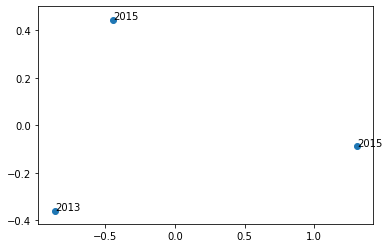

In [11]:
year_pca = PCA(n_components=2)
year_components = year_pca.fit_transform(year_embedding_df.iloc[:,1:])
years = ['2013','2015','2015']
fix, ax = plt.subplots()
ax.scatter(year_components[:,0],year_components[:,1])
for i, txt in enumerate(years):
    ax.annotate(txt, (year_components[i,0],year_components[i,1]))

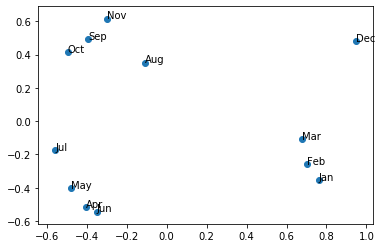

In [12]:
month_pca = PCA(n_components=2)
month_components = month_pca.fit_transform(month_embedding_df.iloc[:,1:])
months = ["Jan","Feb","Mar","Apr","May","Jun",
          "Jul","Aug","Sep","Oct","Nov","Dec"]
fix, ax = plt.subplots()
ax.scatter(month_components[:,0],month_components[:,1])
for i, txt in enumerate(months):
    ax.annotate(txt, (month_components[i,0],month_components[i,1]))

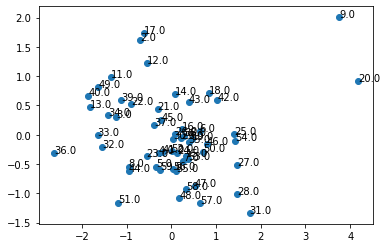

In [13]:
shop_pca = PCA(n_components=2)
shop_components = shop_pca.fit_transform(shop_embedding_df.iloc[:,1:])
shops = list(shop_embedding_df.iloc[:,0])
fix, ax = plt.subplots()
ax.scatter(shop_components[:,0], shop_components[:,1])
for i, txt in enumerate(shops):
    ax.annotate(txt, (shop_components[i,0],shop_components[i,1]))

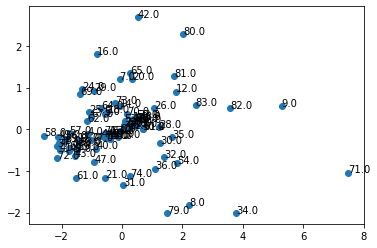

In [17]:
item_cat_pca = PCA(n_components=2)
item_cat_components = item_cat_pca.fit_transform(item_cat_embedding_df.iloc[:,1:])
item_cats = list(item_cat_embedding_df.iloc[:,0])
fix, ax = plt.subplots()
ax.scatter(item_cat_components[:,0], item_cat_components[:,1])
for i, txt in enumerate(item_cats):
    ax.annotate(txt, (item_cat_components[i,0],item_cat_components[i,1]))